# Example of Pretrained Pipelines
Pretrained Pipelines can be considered predefined recipes in the form of Visual NLP pipelines, these recipes come with a set of stages and parameters that help to accomplish specific tasks.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/7.2.SparkOcrPretrainedPipelines.ipynb)

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing Spark OCR
! pip install --upgrade -q spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *
from sparkocr import start
from pyspark import SparkConf

### Initialize Spark session

In [3]:
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)
spark

Spark version: 3.2.1
Spark NLP version: 5.1.1
Spark OCR version: 5.0.2



## Load Pretrained Pipelines

### mixed_scanned_digital_pdf
In this simple pipeline we can use the predefined pipeline to handle a mix of scanned(containing images) and digital PDFs(containing digital text). The output is going to be returned in a Dataframe column, and it will contain texts coming from both sources.</br>
You could even have a single PDF file with a mix of digital and scanned pages.</br>
Other Options:</br>
* __mixed_scanned_digital_pdf_image_cleaner__: same as above but cleaning noise from images.</br>
* __mixed_scanned_digital_pdf_skew_correction__: same as above but with page rotation correction.

In [4]:
from pyspark.ml import PipelineModel
from sparkocr.pretrained import *

mixed_pdf_pipeline = PretrainedPipeline('mixed_scanned_digital_pdf', 'en', 'clinical/ocr')

mixed_scanned_digital_pdf download started this may take some time.
Approx size to download 6.7 KB
[OK!]


### Call the pipeline
We are listing the 'mixed_pdfs' folder, that one contains two PDF files, one is scanned and the other is digital. You can open them yourself and verify.

In [24]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/visual-nlp/data/pdfs/noised.pdf

In [25]:
pdf_path = './noised.pdf'

We will display using the dataframe

In [26]:
pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()
result = mixed_pdf_pipeline.transform(pdf_example_df)
result

+--------------------+--------------------+-------+--------------------+--------------------+----------------+---------------+--------------------+--------------------+-----------+-------+-----------+-----------------+---------+
|                path|    modificationTime| length|                text|           positions|height_dimension|width_dimension|             content|               image|total_pages|pagenum|documentnum|       confidence|exception|
+--------------------+--------------------+-------+--------------------+--------------------+----------------+---------------+--------------------+--------------------+-----------+-------+-----------+-----------------+---------+
|file:/content/noi...|2023-10-12 18:43:...|2115939|-\n\n=\n\npate:\n...|[{[{-\n\n, 1020.0...|             842|            595|[25 50 44 46 2D 3...|{file:/content/no...|          1|      0|          0|61.66992190760425|     null|
+--------------------+--------------------+-------+--------------------+--------------------+----------------+---------------+--------------------+--------------------+-----------+-------+-----------+-----------------+---------+

And to avoid truncation, using collect() on just the text column,

In [27]:
result.select("text").collect()

[Row(text='-\n\n=\n\npate:\n\n‘Sample No. 5031\n\n| Original request made by\n\nMr. €. L. Tucker, Jr.\n\non\n\ni 7/19/68\n\nSample specifications written by\n\nJohn H. M. Bohlken\n\nRECASING\n\nCASING\n\nMENTHOL FLAVOR\n\nOLD GouD STRAIGHT Tobacco Blend\n\ncontrol for Sample No. 5030\n\nBrand\n\nOLD GOLD STRAIGHT\n\n85 mm.\n\nLength\n\n25.3 mm.\n\nPaper\n\nEcusta 556\n\nFirmness\n\nOLD GOLD STRAIGHT\n\nDraw\n\nOLD GOLD STRAIGHT\n\nWeight\n\nOLD GOLD STRAIGHT\n\nWrappings:\n\nTipping Paper --\n\nPrint\n\nLabels ----\n\nOLD GOLD STRAIGHT\n\nClosures---\n\nStandard Blue\n\nC\n\nFilter Length---\n\nTear Tape--\n\nGold\n\n-\n\nCartons ---\n\nOLD GOLD STRAIGHT\n\nSample number on each\n\nLaboratory\n\nOne Tray\n\n.\n\npack and carton\n\nOthers\n\nTars and Nicotine, Taste Panel\n\n,» Burning Time, Gas Phase Analysis,\n\n“Benzo (A) Pyrene Analyses —\n\nResponsibility:\n\nTobacco Blend\n\nFilter Production---\n\nManufacturing - A. Kraus\n\nMaking & Packing --- Product\n\nShipping\n\nDevelopment

### image_handwritten_transformer_extraction
Let's use another example, this time for doing transformer based OCR on handwritten texts. </br>
Other similar options are,

* __image_printed_transformer_extraction__: OCR printed texts contained on images.
* __pdf_printed_transformer_extraction__: OCR printed texts contained in PDFs.
* __pdf_handwritten_transformer_extraction__: OCR handwritten texts contained in PDFs.

In [28]:
from pyspark.ml import PipelineModel
from sparkocr.pretrained import *

image_handwritten_transformer_extraction = PretrainedPipeline('image_handwritten_transformer_extraction', 'en', 'clinical/ocr')

image_handwritten_transformer_extraction download started this may take some time.
Approx size to download 496 MB
[OK!]


### Load image and display it

In [29]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/visual-nlp/data/handwritten_example.jpg


    Image #0:
    Origin: file:/content/handwritten_example.jpg
    Resolution: 0 dpi
    Width: 4608 px
    Height: 3456 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


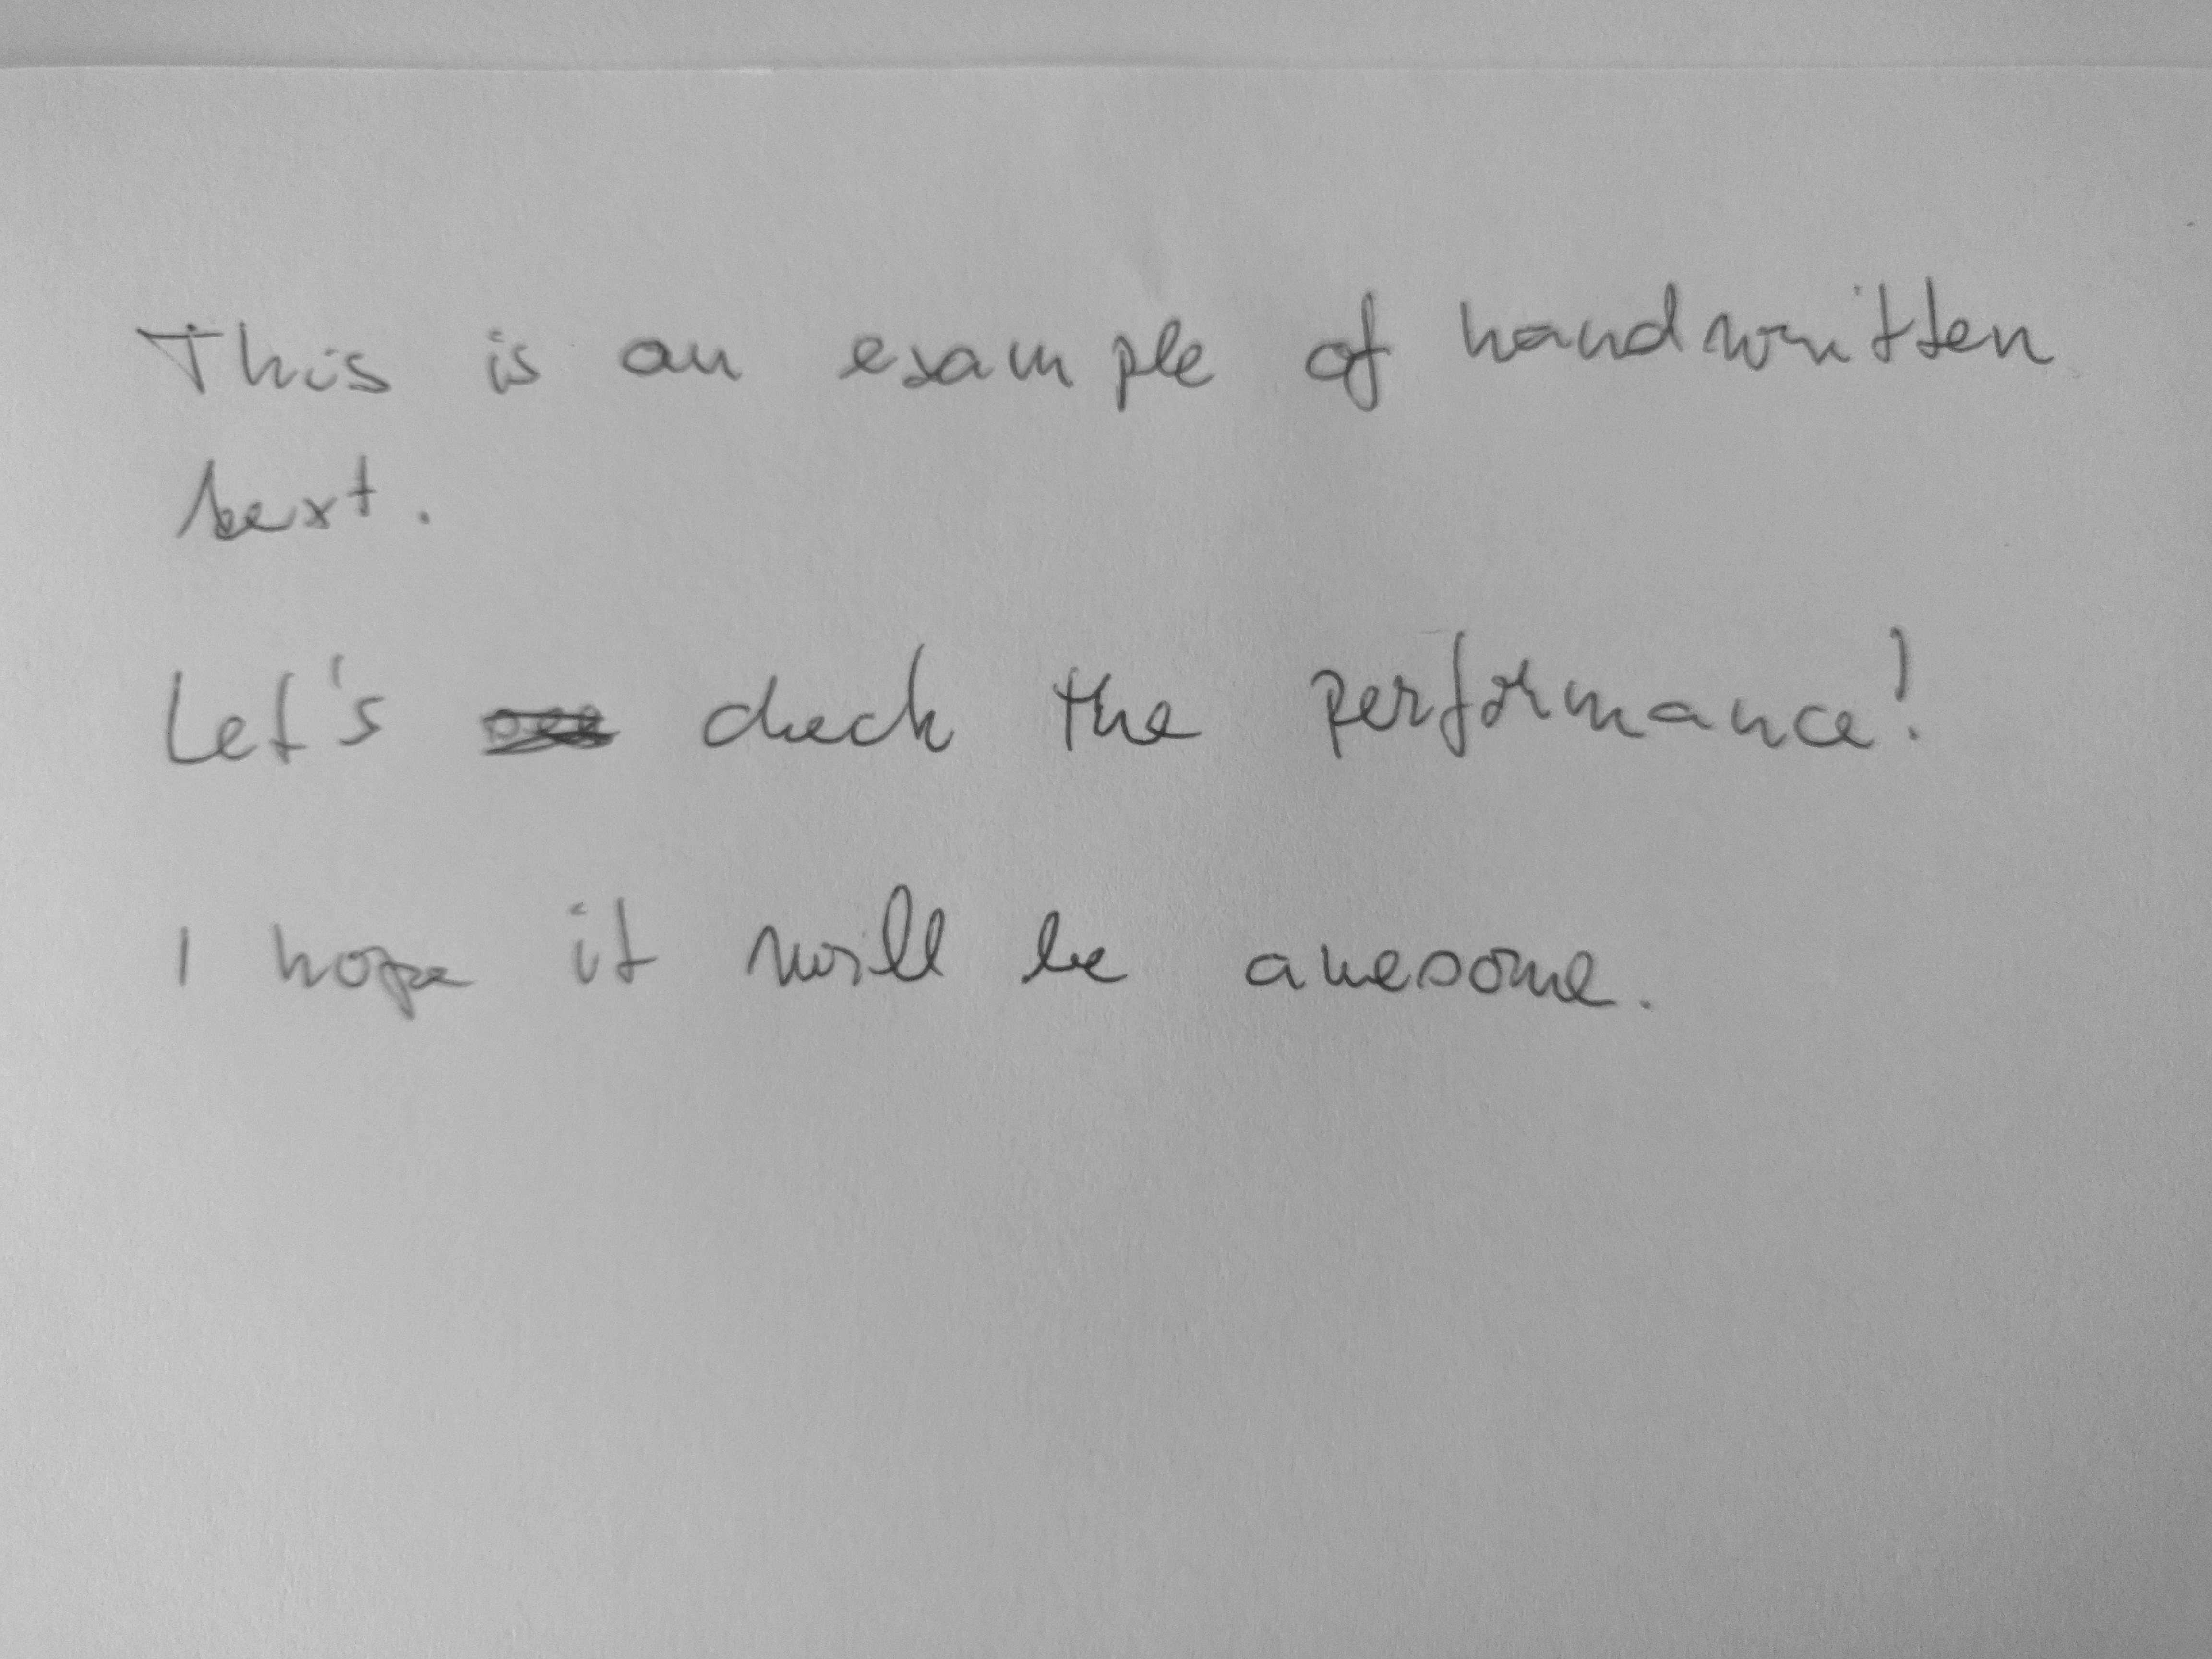

In [31]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

imagePath = "./handwritten_example.jpg"
image_df = spark.read.format("binaryFile").load(imagePath)
display_images(BinaryToImage().transform(image_df), "image")

### display results

In [32]:
result = image_handwritten_transformer_extraction.transform(image_df).cache()
print(("").join([x.text for x in result.select("text").collect()]))

This is an example of handwritten
sex .
Let's # check the performance ?
I hope it will be awesome .
